# Fake News Detection

## Latent Dirichlet Allocation

***
The datasets used in this project are open source and freely available online. The data includes both fake and truthful news articles from multiple domains. The truthful news articles published contain true description of real world events, while the fake news websites contain claims that are not aligned with facts. The conformity of claims from the politics domain for many of those articles can be manually checked with fact checking websites such as politifact.com and snopes.com. I have used three different datasets here:

- The first dataset is called the “ISOT Fake News Dataset” (ds_1) which contains both true and fake articles extracted from the World Wide Web. The true articles are extracted from reuters.com which is a re-nowned news website, while the fake articles were extracted from multiple sources, mostly websites which are flagged by politifact.com. The dataset contains a total of 44,898 articles, out of which 21,417 are truthful articles and 23,481 fake articles. The total corpora contain articles from different domains, but most prominently target political news.
- The second dataset is available at Kaggle (ds_2) and contains a total of 20,386 articles used for training and 5,126 articles used for testing. The dataset is built from multiple sources on the Internet. The articles are not limited to a single domain such as politics as they include both fake and true articles from various other domains.
- The third dataset is also available at Kaggle (ds_3) and includes a total of 3,352 articles, both fake and true. The true articles are extracted from trusted online sources such as CNN, Reuters, the New York Times, and various others, while the fake news articles are extracted from untrusted news websites. The domains it covered include sports, entertainment, and politics.

In [15]:
# dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import Counter

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import seaborn as sns 
import re
import spacy

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:555: Deprecat

In [16]:
df = pd.read_csv('dataset_cleaned.csv', encoding = 'utf-8-sig', engine = 'python')

In [17]:
df.head()

,text,label,char_count,word_count,avg_word,avg_text
0,following transcript donald trumps interview tuesday reporters editors opinion columnists the new york times the transcription prepare liam stack jonah engel bromwich karen workman tim herrera the...,0,39127,6540,4.982875,32588
1,fidel castro fiery apostle revolution bring cold war western hemisphere defy united states nearly half century cubas maximum leader bedevil american presidents briefly push world brink nuclear war...,0,32952,4765,5.915635,28188
2,for last hour american gunship circle high city carefully observe target vision sensors wait clearance strike it morning oct kunduz city envelop total darkness the citys power go five days soon ta...,0,32672,4685,5.973959,27988
3,presidentelect donald trumps first televised interview video cbs minutes trump talks wall deportations roe wade clintons future minutes interview november audio lesley stahl well congratulations m...,1,27033,4548,4.944151,22486
4,presidentelect donald trumps first televised interview video cbs minutes trump talks wall deportations roe wade clintons future minutes interview november audio lesley stahl well congratulations m...,1,27033,4548,4.944151,22486


In [18]:
# Convert to list
data = df.text.values.tolist()

In [19]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

In [20]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [23]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

***
**Create the Document-Word matrix**
***
The LDA topic model algorithm requires a document word matrix as the main input.

In [24]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [25]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.5224378682834815 %


***
**LDA**
***
Let's initially set th number of components to 10. Later we will find the optimal number using grid search.

In [27]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_jobs=1, random_state=100)


A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [28]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

Log Likelihood:  -87306914.68590264


In [29]:
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

Perplexity:  2495.791592345614


In [30]:
# See model parameters
print(lda_model.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': 1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


***
**Grid Search**
***

In [32]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, verbose = 3)

# Do the Grid Search
model.fit(data_vectorized)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ............learning_decay=0.5, n_components=10; total time= 4.8min
[CV 2/5] END ............learning_decay=0.5, n_components=10; total time= 5.3min
[CV 3/5] END ............learning_decay=0.5, n_components=10; total time= 5.7min
[CV 4/5] END ............learning_decay=0.5, n_components=10; total time= 5.9min
[CV 5/5] END ............learning_decay=0.5, n_components=10; total time= 6.1min
[CV 1/5] END ............learning_decay=0.5, n_components=15; total time= 4.9min
[CV 2/5] END ............learning_decay=0.5, n_components=15; total time= 5.7min
[CV 3/5] END ............learning_decay=0.5, n_components=15; total time= 5.7min
[CV 4/5] END ............learning_decay=0.5, n_components=15; total time= 6.2min
[CV 5/5] END ............learning_decay=0.5, n_components=15; total time= 6.7min
[CV 1/5] END ............learning_decay=0.5, n_components=20; total time= 4.9min
[CV 2/5] END ............learning_decay=0.5, n_c

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]},
             verbose=3)

In [33]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 15}
Best Log Likelihood Score:  -17944796.042318974
Model Perplexity:  2403.5796926778435


In [62]:
score = model.cv_results_
pprint(score)

{'mean_fit_time': array([328.37030325, 343.72746406, 366.88301139, 398.45983782,
       416.21494193, 323.13303437, 342.9345778 , 354.37531028,
       452.75219822, 675.27969794, 372.23384266, 407.76394606,
       366.13679161, 421.81414847, 459.61939244]),
 'mean_score_time': array([ 6.56131105,  6.88457479,  7.86148958,  7.98675222,  8.46695981,
        6.38678322,  6.8329143 ,  7.08271956,  8.42762961, 11.41237335,
        7.53261218,  8.39347658,  7.35790648,  8.22003841,  9.93028769]),
 'mean_test_score': array([-17977804.27805608, -17944796.04231897, -18004000.62234506,
       -18037564.36898502, -18081473.30176411, -17944979.81720988,
       -17968608.25194732, -17986772.80763983, -18044810.40912573,
       -18092875.9759169 , -17952647.4902604 , -17965810.17920815,
       -17999886.50582621, -18053303.56866765, -18086128.17025559]),
 'param_learning_decay': masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7, 0.7, 0.9,
                   0.9, 0.9, 0.9, 0.9],
        

***
**Dominant topic**
***

To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In [64]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

In [65]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominant_topic
Doc0,0.000000,0.030000,0.060000,0.060000,0.070000,0.000000,0.010000,0.000000,0.020000,0.050000,0.010000,0.620000,0.060000,0.000000,0.000000,11
Doc1,0.010000,0.000000,0.040000,0.130000,0.000000,0.010000,0.040000,0.000000,0.040000,0.290000,0.090000,0.000000,0.000000,0.350000,0.010000,13
Doc2,0.000000,0.000000,0.030000,0.150000,0.000000,0.030000,0.000000,0.220000,0.000000,0.000000,0.560000,0.000000,0.000000,0.000000,0.000000,10
Doc3,0.010000,0.000000,0.060000,0.000000,0.050000,0.010000,0.000000,0.000000,0.010000,0.010000,0.000000,0.830000,0.010000,0.010000,0.010000,11
Doc4,0.010000,0.000000,0.060000,0.000000,0.050000,0.010000,0.000000,0.000000,0.010000,0.010000,0.000000,0.830000,0.010000,0.010000,0.010000,11
Doc5,0.010000,0.330000,0.000000,0.230000,0.000000,0.000000,0.050000,0.000000,0.000000,0.350000,0.030000,0.000000,0.000000,0.000000,0.000000,9
Doc6,0.000000,0.020000,0.010000,0.110000,0.560000,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,0.140000,0.000000,0.000000,0.000000,4
Doc7,0.020000,0.010000,0.000000,0.800000,0.000000,0.000000,0.000000,0.170000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,3
Doc8,0.300000,0.070000,0.000000,0.070000,0.000000,0.120000,0.000000,0.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,7
Doc9,0.300000,0.070000,0.000000,0.070000,0.000000,0.120000,0.000000,0.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,7


***
**Review topics distribution across documents**
***

In [66]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,11,7540
1,4,5717
2,9,5479
3,10,4857
4,5,4249
5,12,3371
6,7,3277
7,13,3044
8,1,2844
9,6,2677


***
**Visualization**
***

In [67]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      114.344879  114.308296       1        1  11.285158
9      105.821045  -93.749626       2        1  10.331492
11    -138.334473   95.320763       3        1  10.098613
10      -7.436697  111.259697       4        1   8.371311
5     -207.550629 -105.472603       5        1   7.317200
12      52.817650   14.603765       6        1   6.559212
1      168.010849    6.806950       7        1   6.475303
13     -94.169601 -157.789551       8        1   6.216031
3     -122.849174  -39.059418       9        1   6.125872
7      -94.894264  195.408295      10        1   5.978831
14      24.927401 -180.464874      11        1   5.169585
2      -53.413467   26.832108      12        1   4.344359
6      -12.255850  -72.093201      13        1   4.188198
8     -224.217957   28.070581      14        1   3.971063
0       36.154255  209.427582      15        1   3.567773, topic_info=             Term           Freq          Total Category  logprob  loglift
23458       trump  135887.000000  135887.000000  Default  30.0000  30.0000
4135      clinton   42309.000000   42309.000000  Default  29.0000  29.0000
19098  republican   38040.000000   38040.000000  Default  28.0000  28.0000
20043         say  200453.000000  200453.000000  Default  27.0000  27.0000
10444     hillary   22724.000000   22724.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
21718       state    1618.743837   72423.822967  Topic15  -5.5053  -0.4677
9710        group    1376.756814   22208.034887  Topic15  -5.6672   0.5525
18117      public    1319.617612   14721.212552  Topic15  -5.7096   0.9213
8016       family    1306.376732   12488.342872  Topic15  -5.7197   1.0757
21738   statement    1311.994983   15139.763425  Topic15  -5.7154   0.8875

[1340 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
14         8  0.105811       abbas
14         9  0.891837       abbas
48         1  0.004656         abe
48        13  0.019789         abe
48        14  0.974331         abe
...      ...       ...         ...
25670      6  0.994996       zinke
25683      3  0.988962      zucker
25684      6  0.043147  zuckerberg
25684      7  0.954035  zuckerberg
25688      4  0.997450        zuma

[6644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 12, 11, 6, 13, 2, 14, 4, 8, 15, 3, 7, 9, 1])

***
**Topic keywords**
***

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

In [68]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aaplo,aaron,aaronkleinshow,aarp,aba,abaaoud,ababa,aback,abadi,...,zucker,zuckerberg,zuesse,zulia,zum,zuma,zur,zurich,zwei,zwischen
Topic0,0.066667,0.066667,0.066773,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic1,7.987889,0.066667,49.453768,0.066667,0.066667,0.066668,0.066667,0.066667,0.066667,0.066667,...,0.066667,197.314957,0.066667,0.066667,0.066667,0.066667,0.066667,4.551528,0.066667,0.066667
Topic2,0.066667,0.066667,18.343136,0.066667,28.458889,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,11.515487,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic3,1.215575,0.066667,55.379897,15.936959,5.872842,0.066667,0.066667,0.066667,11.326460,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066670,0.066667,0.066667,0.066667,0.066667,0.066667
Topic4,0.066667,0.066667,1.775637,0.066667,0.066667,1.426239,0.066667,0.066667,4.708671,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667


***
**Top Keywords**
***

In [69]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

In [70]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,say,woman,right,court,sexual,year,man,child,tell,people,case,reuter,law,government,sex
Topic 1,use,water,facebook,time,study,new,people,make,change,year,world,say,climate,report,research
Topic 2,republican,health,people,american,care,plan,law,house,obamacare,government,state,make,congress,insurance,pass
Topic 3,say,year,new,time,israel,make,day,people,work,city,home,food,palestinian,israeli,come
Topic 4,trump,say,republican,vote,clinton,election,state,campaign,candidate,voter,president,party,presidential,democratic,poll
Topic 5,clinton,hillary,email,say,fbi,investigation,campaign,election,comey,state,information,report,intelligence,official,department
Topic 6,say,party,government,election,minister,european,vote,leader,reuter,britain,prime,union,germany,political,year
Topic 7,say,shoot,police,gun,game,man,officer,time,tell,team,player,kill,people,report,video
Topic 8,say,china,north,trump,korea,state,united,president,trade,mexico,south,country,reuter,meet,chinese
Topic 9,people,american,black,make,say,america,time,white,man,know,school,think,student,live,come


***
**Topic prediction**
***

In [71]:
mytext = ["The Biden administration officially ended former President Trump’s 'Remain in Mexico' immigration policy this week. The policy, formally known as Migrant Protection Protocols, was implemented in 2019 and required asylum seekers to stay on the Mexican side of the U.S. border while awaiting immigration court proceedings."]

In [72]:
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

In [73]:
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['say', 'state', 'united', 'iran', 'country', 'court', 'president', 'obama', 'refugee', 'administration', 'immigration', 'order', 'security', 'trump', 'government']


***
**Cluster documents that share similar topics**
***

We can use k-means clustering on the document-topic probability matrix, which is simply our lda_output object. Since out best model has 15 clusters, we can set n_clusters=15 in KMeans().

In [74]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

In [75]:
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

In [76]:
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

In [77]:
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

Component's weights: 
 [[ 0.08  0.13  0.11  0.11  0.45  0.26  0.08  0.14  0.1   0.32  0.2   0.67
   0.15  0.13  0.12]
 [ 0.07  0.08  0.01  0.08 -0.16 -0.03  0.18  0.11  0.17  0.06  0.85 -0.33
   0.1   0.17  0.06]]


In [78]:
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Perc of Variance Explained: 
 [0.05 0.12]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

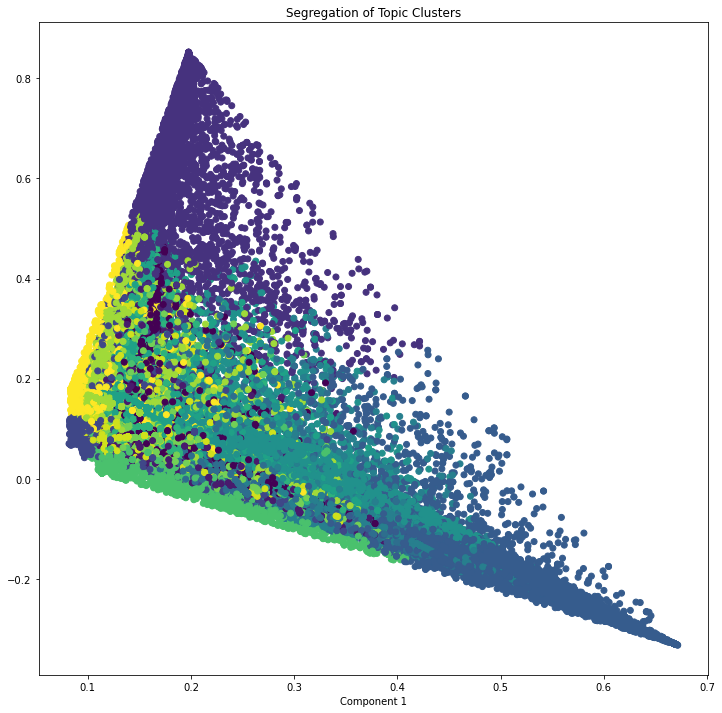

In [79]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )